# Algorithm prototyping

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely as sh
import shapely.geometry as shg
import shapely.ops as sho
from datetime import datetime

In [2]:
from pyproj import CRS, Transformer

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils import get_sun_state

## Helper functions

In [6]:
crs_4326 = CRS.from_epsg(4326) # WGS84
crs_25832 = CRS.from_epsg(25832) # ETRS89 / UTM zone 32N
to_wgs_84_transformer = Transformer.from_crs(crs_25832, crs_4326)
to_utm_transformer = Transformer.from_crs(crs_4326, crs_25832)

In [7]:
df = pd.read_csv("data\extracted\dom1l-fp_32349_5660_1_nw.csv")

In [8]:
df = df.sample(50000)

In [9]:
df = gpd.GeoDataFrame(df)

In [10]:
df.head()

,x,y,z,lat,lon
1771007,349217.83,5660626.72,50.97,51.077316,6.847490
4760740,349642.06,5660145.42,56.81,51.073102,6.853742
4781666,349646.32,5660706.47,36.42,51.078145,6.853569
1012059,349118.10,5660473.97,54.59,51.075917,6.846131
322613,349040.81,5660546.09,49.81,51.076544,6.844998


In [11]:
# creating a geometry column 
geometry = [sh.geometry.Point(xy) for xy in zip(df['lon'], df['lat'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

In [12]:
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df[["x", "y", "z"]], crs=crs, geometry=geometry)

In [13]:
gdf.head()

,x,y,z,geometry
1771007,349217.83,5660626.72,50.97,POINT (6.847489901920669 51.07731552459477)
4760740,349642.06,5660145.42,56.81,POINT (6.853741670688978 51.07310184731246)
4781666,349646.32,5660706.47,36.42,POINT (6.853569090476133 51.07814459681858)
1012059,349118.10,5660473.97,54.59,POINT (6.846131026552107 51.0759166953012)
322613,349040.81,5660546.09,49.81,POINT (6.844998415116534 51.07654443984316)


In [14]:
lat_q, lon_q = 51.078534, 6.844748
query_point = shg.Point(lat_q, lon_q)

In [15]:
# filter to 100m around query point first
R = 50
query_point_xy = shg.Point(to_utm_transformer.transform(lon_q, lat_q))
query_region_xy = query_point_xy.buffer(R, resolution=16)
query_region_wgs84 = sho.transform(to_wgs_84_transformer.transform, query_region_xy)

In [16]:
gdf_query = gdf[gdf.intersects(query_region_wgs84)]

In [17]:
len(gdf_query), len(gdf)

(170, 50000)

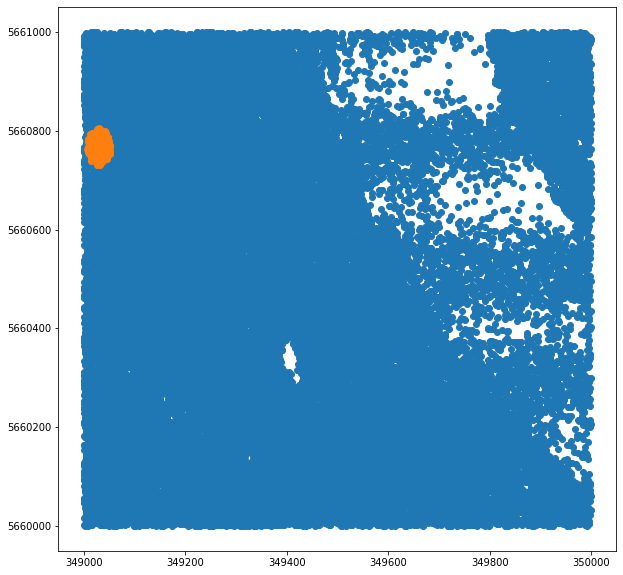

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(gdf["x"], gdf["y"])
plt.scatter(gdf_query["x"], gdf_query["y"])

In [19]:
# get nearest point to the query point
query_nearest_point = gdf_query.loc[gdf_query.distance(sh.geometry.Point(lon_q, lat_q)).idxmin()]

This point is now the origin of the projected axis, so we have to remove the offset of other points

In [20]:
query_nearest_point

x                                                349030
y                                           5.66077e+06
z                                                 43.99
geometry    POINT (6.844746710492507 51.07852578992837)
Name: 235141, dtype: object

In [21]:
gdf_query["x_proj"] = gdf_query["x"] - query_nearest_point["x"]
gdf_query["y_proj"] = gdf_query["y"] - query_nearest_point["y"]

c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
gdf_query.head()

,x,y,z,geometry,x_proj,y_proj
144333,349017.92,5660792.55,43.87,POINT (6.844568954984084 51.07875311011469),-11.71,25.64
102202,349012.68,5660772.92,46.80,POINT (6.844502405074643 51.0785753359341),-16.95,6.01
232111,349029.25,5660779.57,44.03,POINT (6.844736001875348 51.07863945284269),-0.38,12.66
376307,349047.29,5660759.96,64.63,POINT (6.845001536246603 51.07846798333761),17.66,-6.95
333062,349042.09,5660766.27,44.02,POINT (6.84492472202689 51.0785233170566),12.46,-0.64


## Sunstate

In [23]:
query_time = datetime(2019, 7, 21, 9, 0, 0)

In [24]:
zen, azimuth = get_sun_state(lat_q, lon_q, query_time)
print(zen, azimuth)

43.55304490574677 119.59839270773891
